In [80]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from matplotlib import pyplot as plt
import seaborn as sns
from collections import Counter
from os.path import join
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.base import clone
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import dendrogram
from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm



In [46]:
data = pd.read_csv("data_preprocessing.csv")

In [47]:
data = data.set_index("ID")

In [48]:
data.columns

Index(['Age', 'Income', 'DaysWithoutFrequency', 'LifetimeValue', 'UseByTime',
       'AthleticsActivities', 'WaterActivities', 'FitnessActivities',
       'TeamActivities', 'RacketActivities', 'CombatActivities',
       'SpecialActivities', 'OtherActivities', 'NumberOfFrequencies',
       'AttendedClasses', 'AllowedWeeklyVisitsBySLA',
       'AllowedNumberOfVisitsBySLA', 'RealNumberOfVisits', 'NumberOfRenewals',
       'HasReferences', 'NumberOfReferences', 'Dropout', 'Active_Period',
       'Contract_Duration', 'PercentageOfVisits', 'TotalNumberOfActivities',
       'MonthlyValue', 'PercentageOfClasses', 'Freq_Visits_Day',
       'Freq_Classes_Contract', 'Visits_ActivePeriod', 'Gender_Female'],
      dtype='object')

In [49]:
metric_features = ['Age', 'Income', 'DaysWithoutFrequency', 'LifetimeValue', 'NumberOfFrequencies',
       'AttendedClasses', 'AllowedWeeklyVisitsBySLA',
       'AllowedNumberOfVisitsBySLA', 'RealNumberOfVisits', 'NumberOfRenewals', 'NumberOfReferences', 'Active_Period', 'Contract_Duration', 'PercentageOfVisits', 'TotalNumberOfActivities',
       'MonthlyValue', 'PercentageOfClasses', 'Freq_Visits_Day',
       'Freq_Classes_Contract', 'Visits_ActivePeriod']

non_metric_features = data.columns.drop(metric_features).to_list()

## Variable Selection: Redundancy VS Relevancy

#### Correlation Matrix:

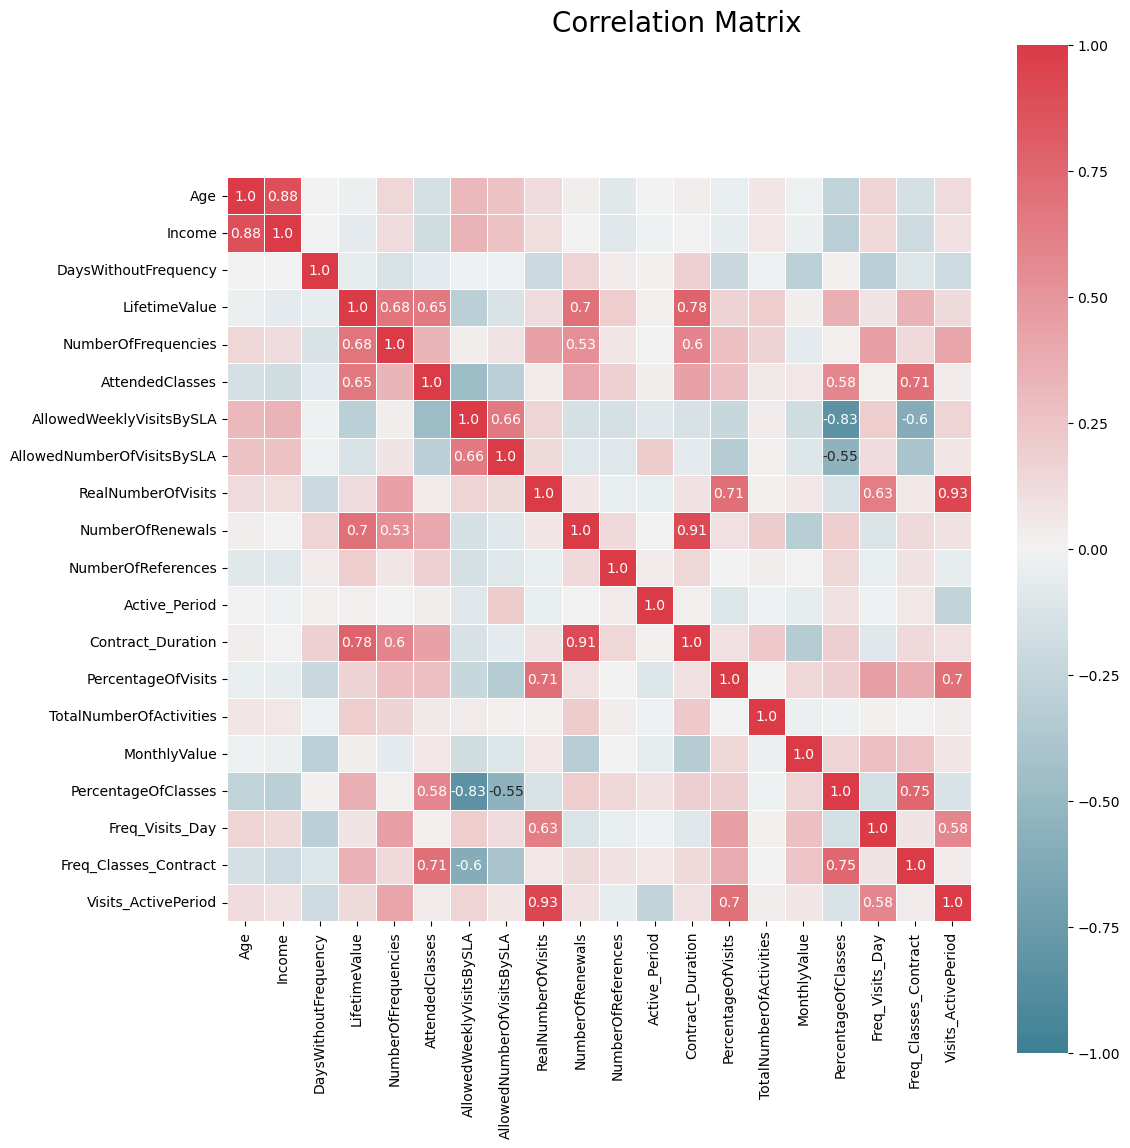

In [50]:
# Prepare figure
fig = plt.figure(figsize=(12, 12))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(data[metric_features].corr(method="pearson"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values)>= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) # Try to understand what this np.where() does

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix", fontsize=20)

#plt.savefig(os.path.join('..', 'figures', 'exp_analysis', 'correlation_matrix.png'), dpi=200)

plt.show()

We uncover some important information:
- `Age` and  `Income` are highly correlated.
- `LifetimeValue` is also very correlated with `NumberOfRenewals`, `NumberOfFrequencies`, `AttendedClasses` and `ContractDuration`;
- `NumberOfFrequencies` is correlated with `NumberOfRenewals` and `ContractDuration`
- `AttendedClasses` is correlated with `PercentageOfClasses` and `Freq_Classes_Contract`
- `AllowedWeeklyVisitsBySLA` is highly negatively correlated with `PercentageOfClasses` and correlated with `AllowedNumberOfVisitsBySLA`
- `Visits_ActivePeriord` is highly correlated with `RealNumberOfVisits`.


1) We remove `Income` as we are looking to understand the different age groups in our sports facility.

In [51]:
data.drop("Income", axis =1, inplace = True)

2) We remove `RealNumberOfVisits` as `Visits_ActivePeriod` is more relevant to study client behaviour as it is a value that is defined in the same time frame for all clients.

In [52]:
data.drop("RealNumberOfVisits", axis =1, inplace = True)

3) We drop `DaysWithoutFrequency` as it has no correlation with other variables and can be considered "noise"

In [53]:
data.drop("DaysWithoutFrequency", axis =1, inplace = True)

5) For the same reasons we drop `TotalNumberOfActivities`, `MonthlyValue`, `ActivePeriod` and `NumberOfReferences`

In [54]:
data.drop(["TotalNumberOfActivities","MonthlyValue", "Active_Period", "NumberOfReferences" , "HasReferences"], axis =1, inplace = True)

Since we drop `NumberOfReferences` and `HasReferences` is related with this variable and highly unbalanced, we decide to drop it too.

6) We drop `LifetimeValue` as it has correlations with many other variable and can be considered redunctant.

In [55]:
data.drop("LifetimeValue", axis =1, inplace = True)

7) Between `AttendedClasses` , `Freq_Classes_Contract` and `PercentageOfClasses`:

In [56]:
data.drop("AttendedClasses", axis =1, inplace = True)

8) `AllowedWeeklyVisitsBySLA` and `AllowedNumberOfVisitsBySLA` and ``RealNumberOfVisits

In [57]:
data.drop("AllowedWeeklyVisitsBySLA", axis =1, inplace = True)
data.drop("AllowedNumberOfVisitsBySLA", axis =1, inplace = True)

9) Between `NumberOfRenewals` and `ContractDuration`, the second variable is kept as we have no information about the renewal process of the company.

In [58]:
data.drop("NumberOfRenewals", axis =1, inplace = True)

10) `NumberOfFrequencies` is droped once we have other variables such as `Freq_Visits_Day` that offers a more informative insight about the data

In [59]:
data.drop("NumberOfFrequencies", axis =1, inplace = True)

11) `Freq_Classes_Contract` is droped because has a high correlation with `PercentageOfClasses`

In [60]:
data.drop("Freq_Classes_Contract", axis =1, inplace = True)

In [61]:
# update metric and non metric features
metric_features = ['Age','Contract_Duration', 'PercentageOfVisits', 'PercentageOfClasses','Freq_Visits_Day', 'Visits_ActivePeriod']
non_metric_features = data.columns.drop(metric_features).to_list()

In [62]:
activities = ['AthleticsActivities', 'WaterActivities','FitnessActivities','TeamActivities','RacketActivities','CombatActivities','SpecialActivities','OtherActivities']


### Detection of outliers through DBSCAN

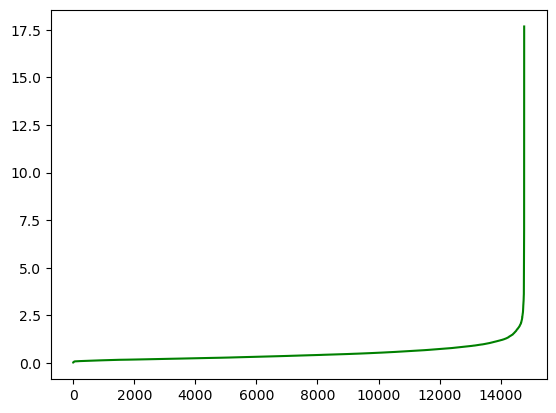

In [63]:
# epsilon of 2.2
neigh = NearestNeighbors(n_neighbors = (2 * len(metric_features)) - 1)
neigh.fit(data[metric_features])
distances, _ = neigh.kneighbors(data[metric_features])
distances = np.sort(distances[:, -1])
#plt.yticks(np.arange(1,22,0.5))
plt.plot(distances, color = 'green')
plt.show()

In [64]:
from collections import Counter

from sklearn.cluster import DBSCAN


dbscan = DBSCAN(eps=2.25, min_samples = 2 * len(metric_features), n_jobs = -1)
dbscan_labels = dbscan.fit_predict(data[metric_features])

Counter(dbscan_labels)

Counter({0: 14744, -1: 29})

In [65]:
data.shape

(14773, 17)

In [66]:
data = pd.concat([data, pd.Series(dbscan_labels, name = 'dbscan_labels', index = data.index)], axis =1)
data_dbscan_out = data[dbscan_labels == -1]
data = data[dbscan_labels != -1]

In [67]:
data.shape

(14744, 18)

In [68]:
data.shape

(14744, 18)

In [75]:
general_perspective = metric_features
compare = ['UseByTime','Dropout', 'Gender_Female']
df_activities = data[activities].copy()
df_general = data[general_perspective].copy()
df_compare = data[compare].copy()

## K-Means

In [76]:
range_clusters = range(1, 11)
inertia = []
for n_clus in range_clusters:  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(df_general[metric_features])
    inertia.append(kmclust.inertia_)  # save the inertia of the given cluster solution

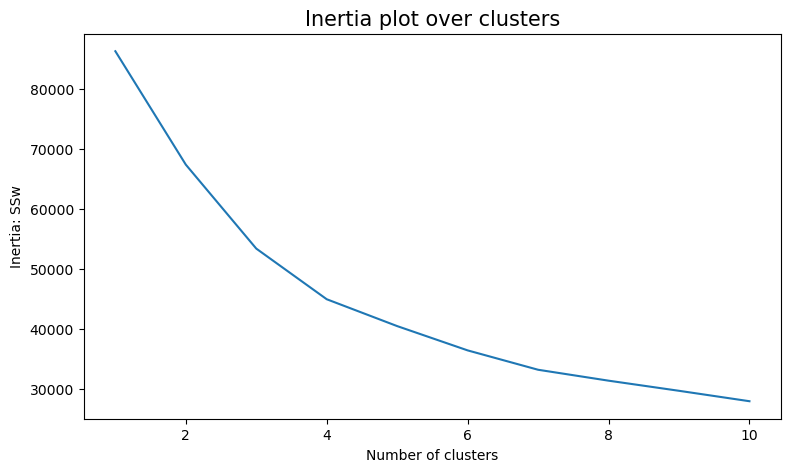

In [77]:
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(range_clusters, inertia)
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

For n_clusters = 2, the average silhouette_score is : 0.33730838119454604
For n_clusters = 3, the average silhouette_score is : 0.31865683542466916
For n_clusters = 4, the average silhouette_score is : 0.32117164717423335
For n_clusters = 5, the average silhouette_score is : 0.32224736296429735
For n_clusters = 6, the average silhouette_score is : 0.286310452613154
For n_clusters = 7, the average silhouette_score is : 0.29250212811153165
For n_clusters = 8, the average silhouette_score is : 0.2972155638160565
For n_clusters = 9, the average silhouette_score is : 0.263509627415237
For n_clusters = 10, the average silhouette_score is : 0.26755385771204754


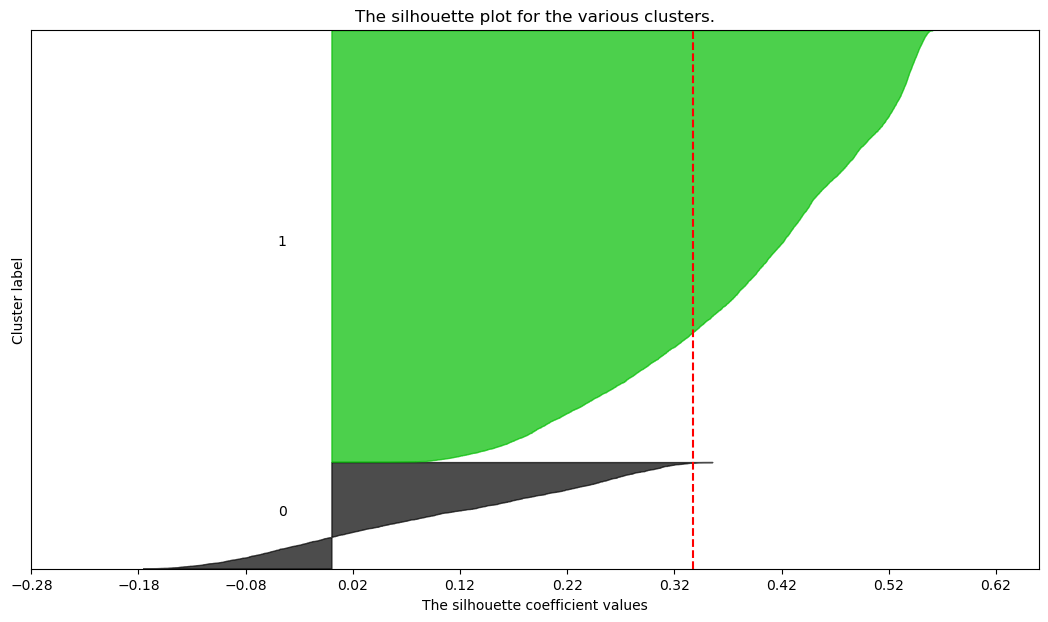

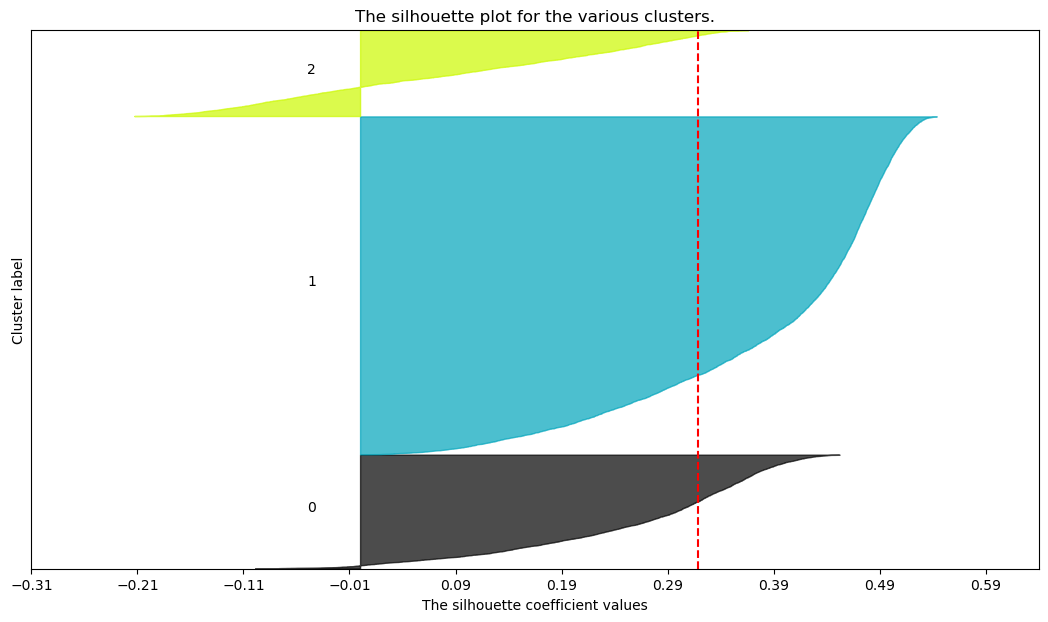

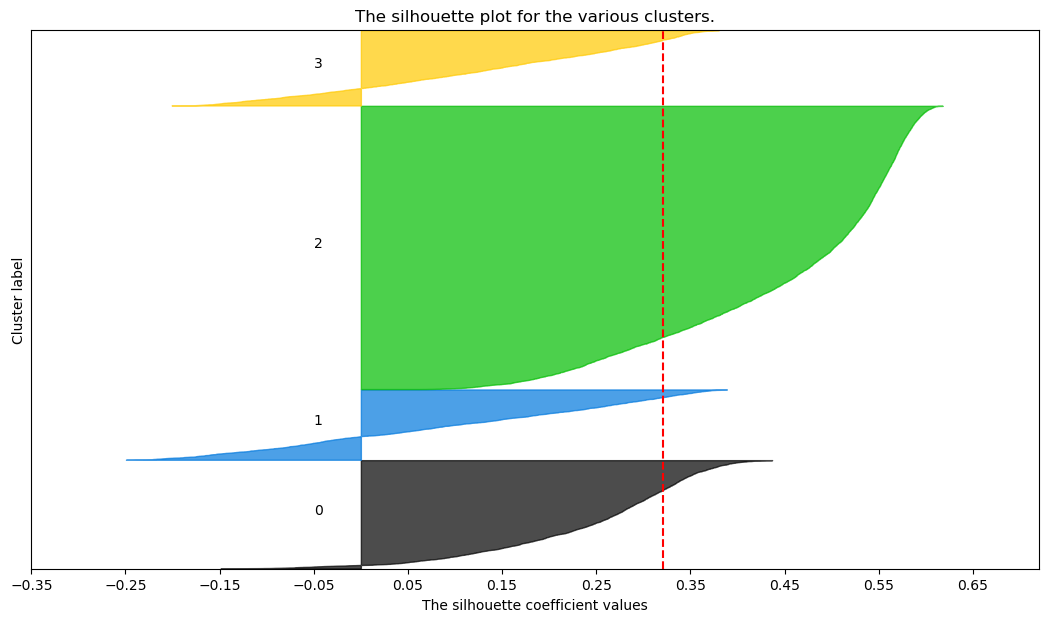

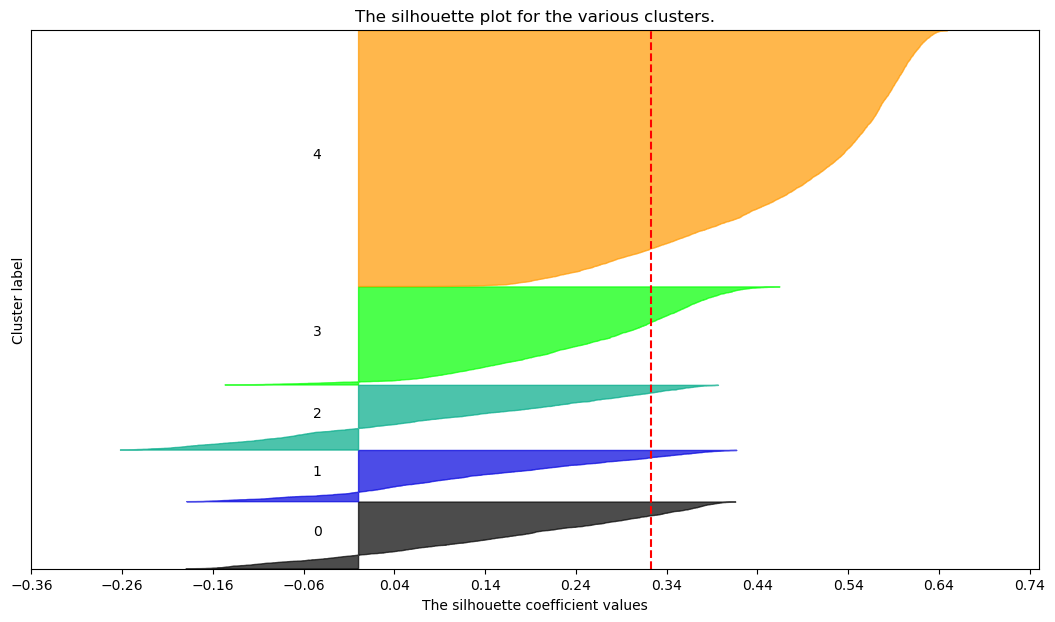

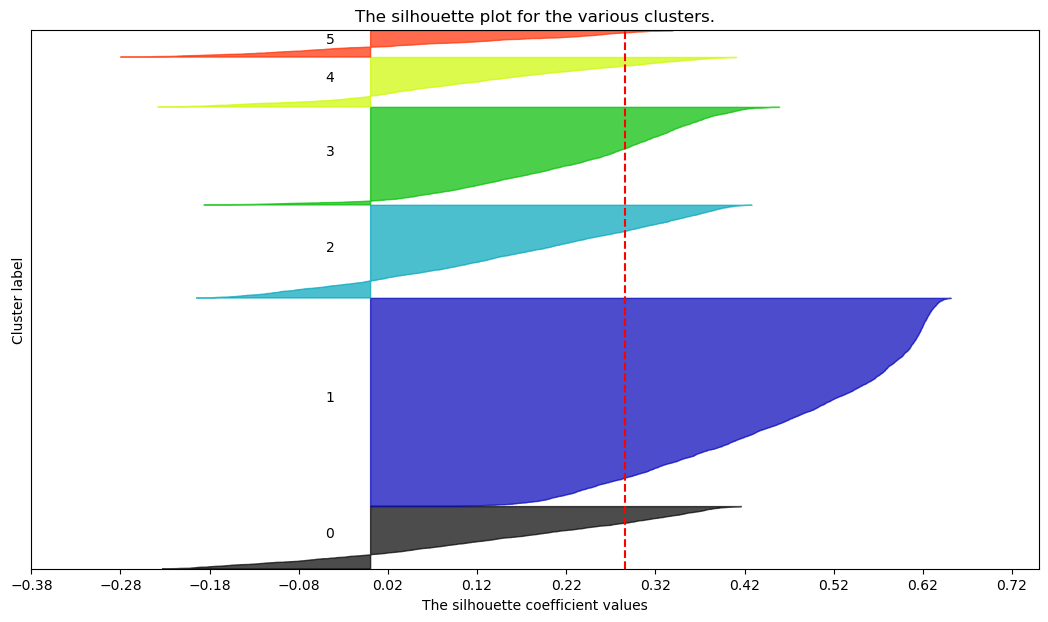

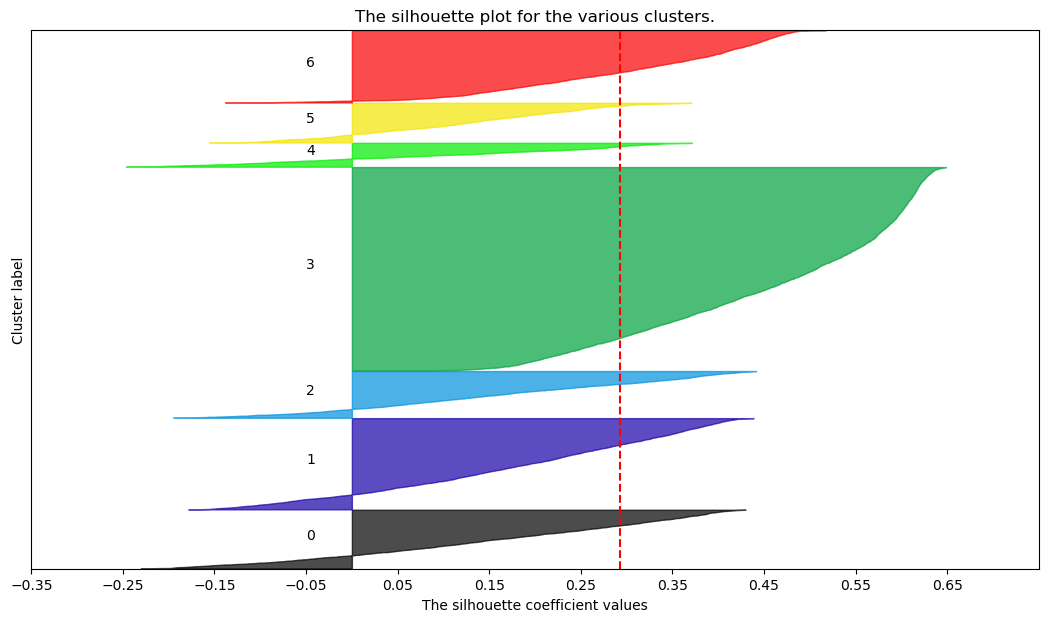

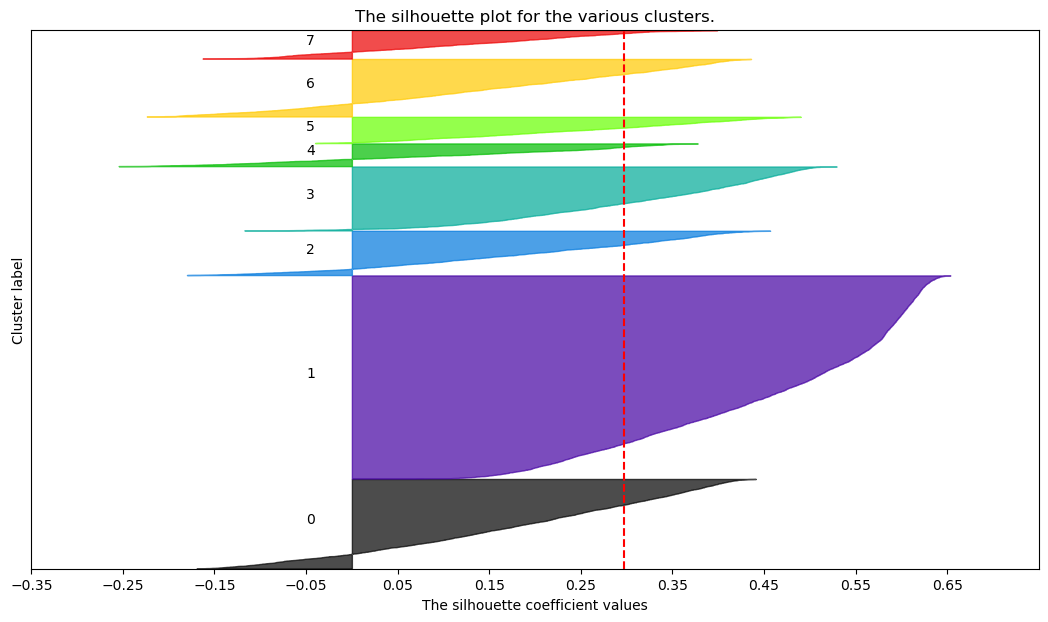

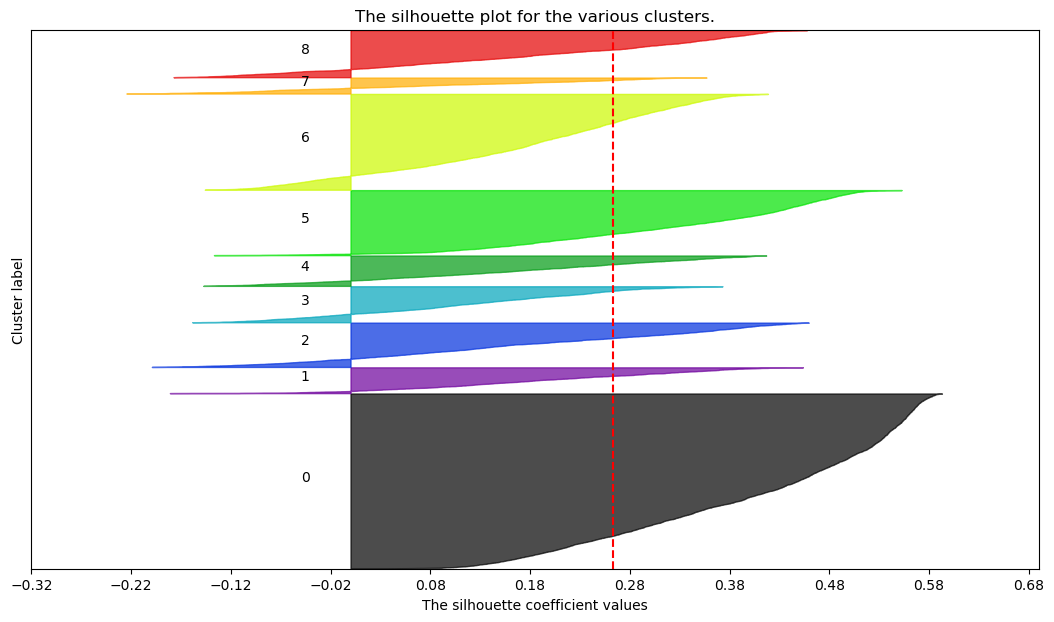

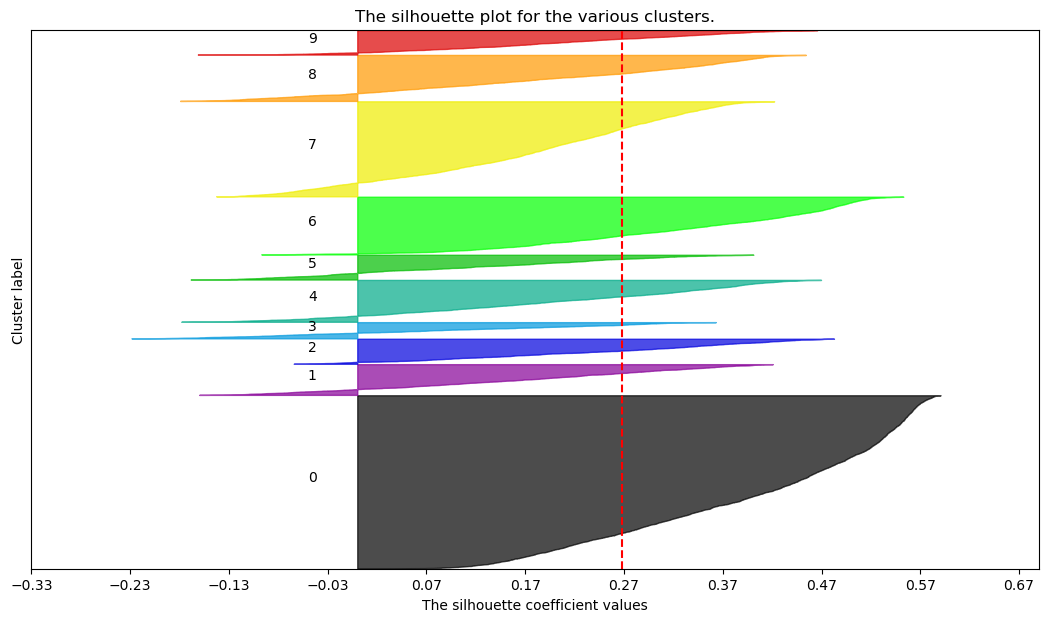

In [82]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

# Storing average silhouette metric
avg_silhouette = []
for nclus in range_clusters:
    # Skip nclus == 1
    if nclus == 1:
        continue
    
    # Create a figure
    fig = plt.figure(figsize=(13, 7))

    # Initialize the KMeans object with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=1)
    cluster_labels = kmclust.fit_predict(df_general[metric_features])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(df_general[metric_features], cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_general[metric_features], cluster_labels)

    y_lower = 10
    for i in range(nclus):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        # Get y_upper to demarcate silhouette y range size
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        # Filling the silhouette
        color = cm.nipy_spectral(float(i) / nclus)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    # The silhouette coefficient can range from -1, 1
    xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
    plt.xlim([xmin, xmax])
    
    # The (nclus+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    plt.ylim([0, len(df_general[metric_features]) + (nclus + 1) * 10])

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks(np.arange(xmin, xmax, 0.1))

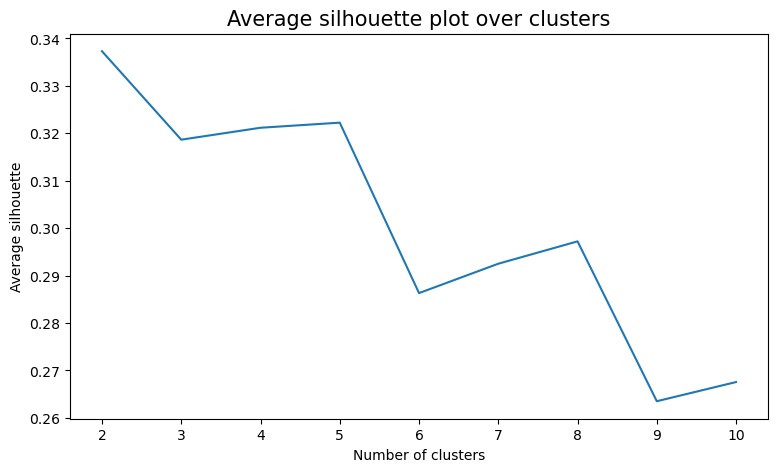

In [83]:
# The average silhouette plot
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(range_clusters[1:], ## Plot X-axis; Why range_clusters[1:] ? Remember we skipped k=1 in the cell above
         avg_silhouette)     ## Plot Y-axis

plt.ylabel("Average silhouette")
plt.xlabel("Number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.show()

In [86]:
# final cluster solution
number_clusters = 4
kmclust = KMeans(n_clusters=number_clusters, init='k-means++', n_init=15, random_state=1)
km_labels = kmclust.fit_predict(df_general[metric_features])
km_labels

array([3, 2, 2, ..., 1, 1, 1])

In [87]:
# Characterizing the final clusters
df_concat = pd.concat((df_general, pd.Series(km_labels, name='labels', index=df_general.index)), axis=1)
df_concat.groupby('labels').mean()

,Age,Contract_Duration,PercentageOfVisits,PercentageOfClasses,Freq_Visits_Day,Visits_ActivePeriod
labels,,,,,,
0,-0.826321,0.666862,0.517620,2.151567,-0.090761,-0.072010
1,0.585967,0.325520,1.533938,0.234040,1.730748,2.229025
2,0.038832,0.112568,-0.055923,0.025563,0.048540,-0.006889
3,2.313789,0.569720,-0.013564,0.519293,0.151914,-0.035573


In [88]:
cluster_means = df_concat.groupby('labels').mean()[metric_features].T
cluster_means.style.format(precision=2).background_gradient(axis=1)

labels,0,1,2,3
Age,-0.83,0.59,0.04,2.31
Contract_Duration,0.67,0.33,0.11,0.57
PercentageOfVisits,0.52,1.53,-0.06,-0.01
PercentageOfClasses,2.15,0.23,0.03,0.52
Freq_Visits_Day,-0.09,1.73,0.05,0.15
Visits_ActivePeriod,-0.07,2.23,-0.01,-0.04


In [89]:
def cluster_profiles(df, label_columns, figsize, compar_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)
        
    sns.set()
    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
       
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
        sns.barplot(x=label, y="counts", data=counts, ax=ax[1])

        
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].legend(handles, cluster_labels) 
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20)
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
    
    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profilling", fontsize=23)
    plt.show()

In [90]:
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

sst = get_ss(df_concat[metric_features])  # get total sum of squares
ssw_labels = df_concat[metric_features + ["labels"]].groupby(by='labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
r2

0.47895667092601757

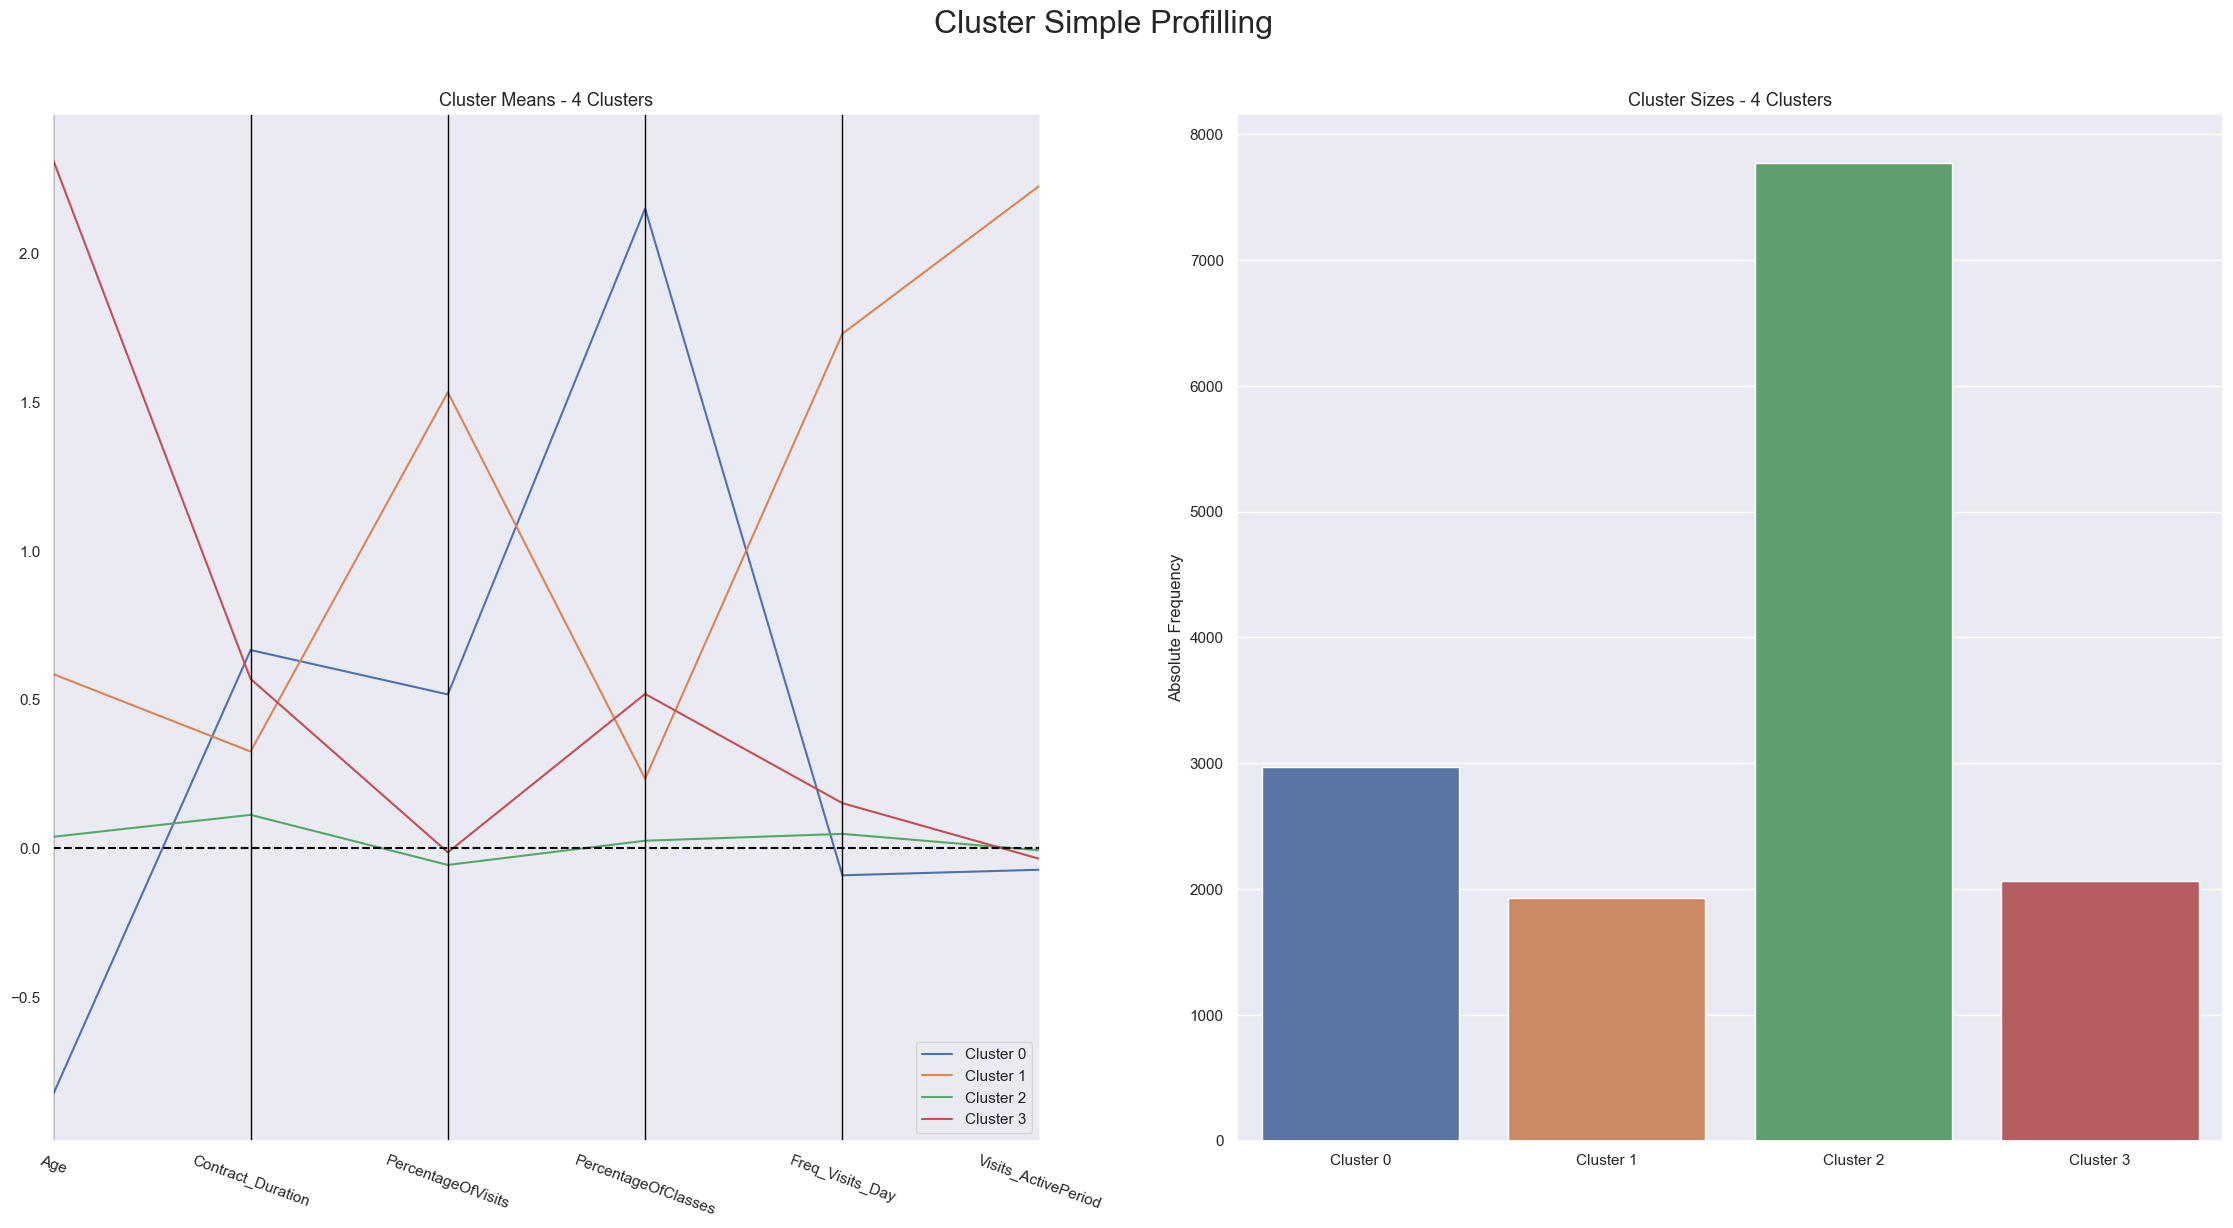

In [91]:
cluster_profiles(
    df = df_concat[metric_features + ["labels"]], 
    label_columns = ["labels"], 
    figsize = (28, 13), 
    compar_titles = [""]
)

## K means + Hierarchial clustering

In [92]:
from sklearn.cluster import KMeans


def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

def r2(df, labels):
    sst = get_ss(df)
    ssw = np.sum(df.groupby(labels).apply(get_ss))
    return 1 - ssw/sst
    
def get_r2_scores(df, clusterer, min_k=2, max_k=10):
    """
    Loop over different values of k. To be used with sklearn clusterers.
    """
    r2_clust = {}
    for n in range(min_k, max_k):
        clust = clone(clusterer).set_params(n_clusters=n)
        labels = clust.fit_predict(df)
        r2_clust[n] = r2(df, labels)
    return r2_clust


# Set up the clusterers
kmeans = KMeans(
    init='k-means++',
    n_init=20,
    random_state=42
)

hierarchical = AgglomerativeClustering(
    metric='euclidean'
)

In [93]:
# Obtaining the R² scores for each cluster solution on demographic variables
r2_scores = {}
r2_scores['kmeans'] = get_r2_scores(df_general, kmeans)

for linkage in ['complete', 'average', 'single', 'ward']:
    r2_scores[linkage] = get_r2_scores(
        df_general, hierarchical.set_params(linkage=linkage)
    )

pd.DataFrame(r2_scores)

,kmeans,complete,average,single,ward
2,0.219025,0.146594,0.004150,0.000469,0.168877
3,0.381156,0.160850,0.140353,0.001550,0.296483
4,0.478957,0.173024,0.151791,0.002046,0.385265
5,0.530824,0.284203,0.152013,0.004393,0.444234
6,0.577722,0.287106,0.153650,0.004773,0.499722
7,0.615128,0.301918,0.200299,0.005415,0.539658
8,0.636229,0.364574,0.215663,0.005809,0.570491
9,0.657115,0.368153,0.217706,0.006202,0.595708


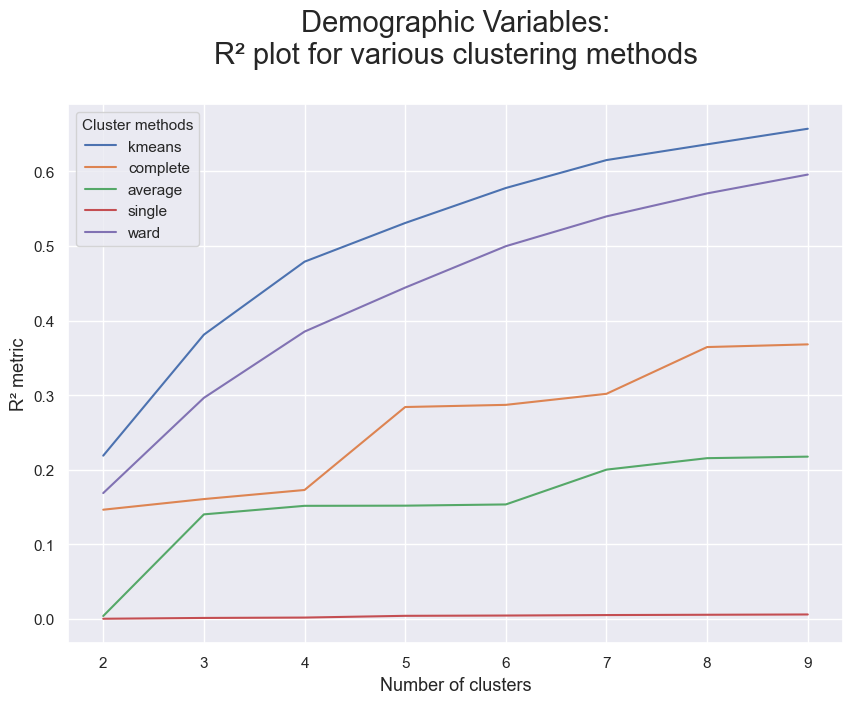

In [94]:
# Visualizing the R² scores for each cluster solution on demographic variables
pd.DataFrame(r2_scores).plot.line(figsize=(10,7))

plt.title("Demographic Variables:\nR² plot for various clustering methods\n", fontsize=21)
plt.legend(title="Cluster methods", title_fontsize=11)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R² metric", fontsize=13)
plt.show()

In [95]:
from sklearn.cluster import KMeans


kmeans_attendance = KMeans(
    n_clusters=4,
    init='k-means++',
    n_init=20,
    random_state=42
)
attendance_labels = kmeans_attendance.fit_predict(df_general)
data['attendance_labels'] = attendance_labels


In [96]:
df_centroids = data.groupby(['attendance_labels'])\
    [metric_features].mean()
df_centroids

,Age,Contract_Duration,PercentageOfVisits,PercentageOfClasses,Freq_Visits_Day,Visits_ActivePeriod
attendance_labels,,,,,,
0,0.585967,0.325520,1.533938,0.234040,1.730748,2.229025
1,2.313789,0.569720,-0.013564,0.519293,0.151914,-0.035573
2,-0.826321,0.666862,0.517620,2.151567,-0.090761,-0.072010
3,0.038832,0.112568,-0.055923,0.025563,0.048540,-0.006889


In [97]:
linkage = 'ward'
hclust = AgglomerativeClustering(
    linkage=linkage, 
    metric='euclidean', 
    distance_threshold=0, 
    n_clusters=None
)
hclust_labels = hclust.fit_predict(df_centroids)

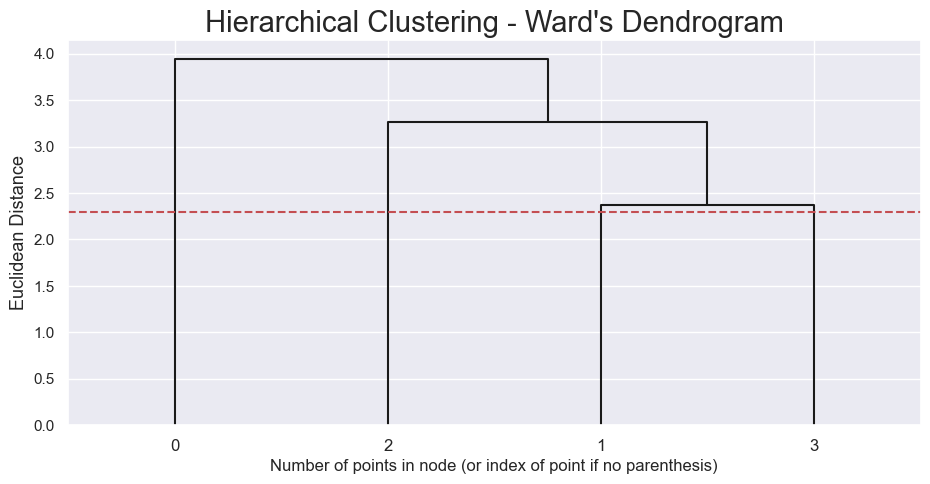

In [98]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 2.3
dendrogram(linkage_matrix, 
           truncate_mode='level', 
           labels=df_centroids.index, p=5, 
           color_threshold=y_threshold, 
           above_threshold_color='k')

plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'Euclidean Distance', fontsize=13)
plt.show()

In [99]:
# Re-running the Hierarchical clustering based on the correct number of clusters
hclust = AgglomerativeClustering(
    linkage='ward', 
    metric='euclidean', 
    n_clusters=4
)
hclust_labels = hclust.fit_predict(df_centroids)
df_centroids['hclust_labels'] = hclust_labels

df_centroids  # centroid's cluster labels

,Age,Contract_Duration,PercentageOfVisits,PercentageOfClasses,Freq_Visits_Day,Visits_ActivePeriod,hclust_labels
attendance_labels,,,,,,,
0,0.585967,0.325520,1.533938,0.234040,1.730748,2.229025,3
1,2.313789,0.569720,-0.013564,0.519293,0.151914,-0.035573,1
2,-0.826321,0.666862,0.517620,2.151567,-0.090761,-0.072010,2
3,0.038832,0.112568,-0.055923,0.025563,0.048540,-0.006889,0


In [100]:
def cluster_profiles(df, label_columns, figsize, compar_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)
        
    sns.set()
    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        # Filtering df
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Getting the cluster centroids and counts
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # Setting Data
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
        sns.barplot(x=label, y="counts", data=counts, ax=ax[1])

        #Setting Layout
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].legend(handles, cluster_labels) # Adaptable to number of clusters
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20)
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
    
    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profilling", fontsize=23)
    plt.show()

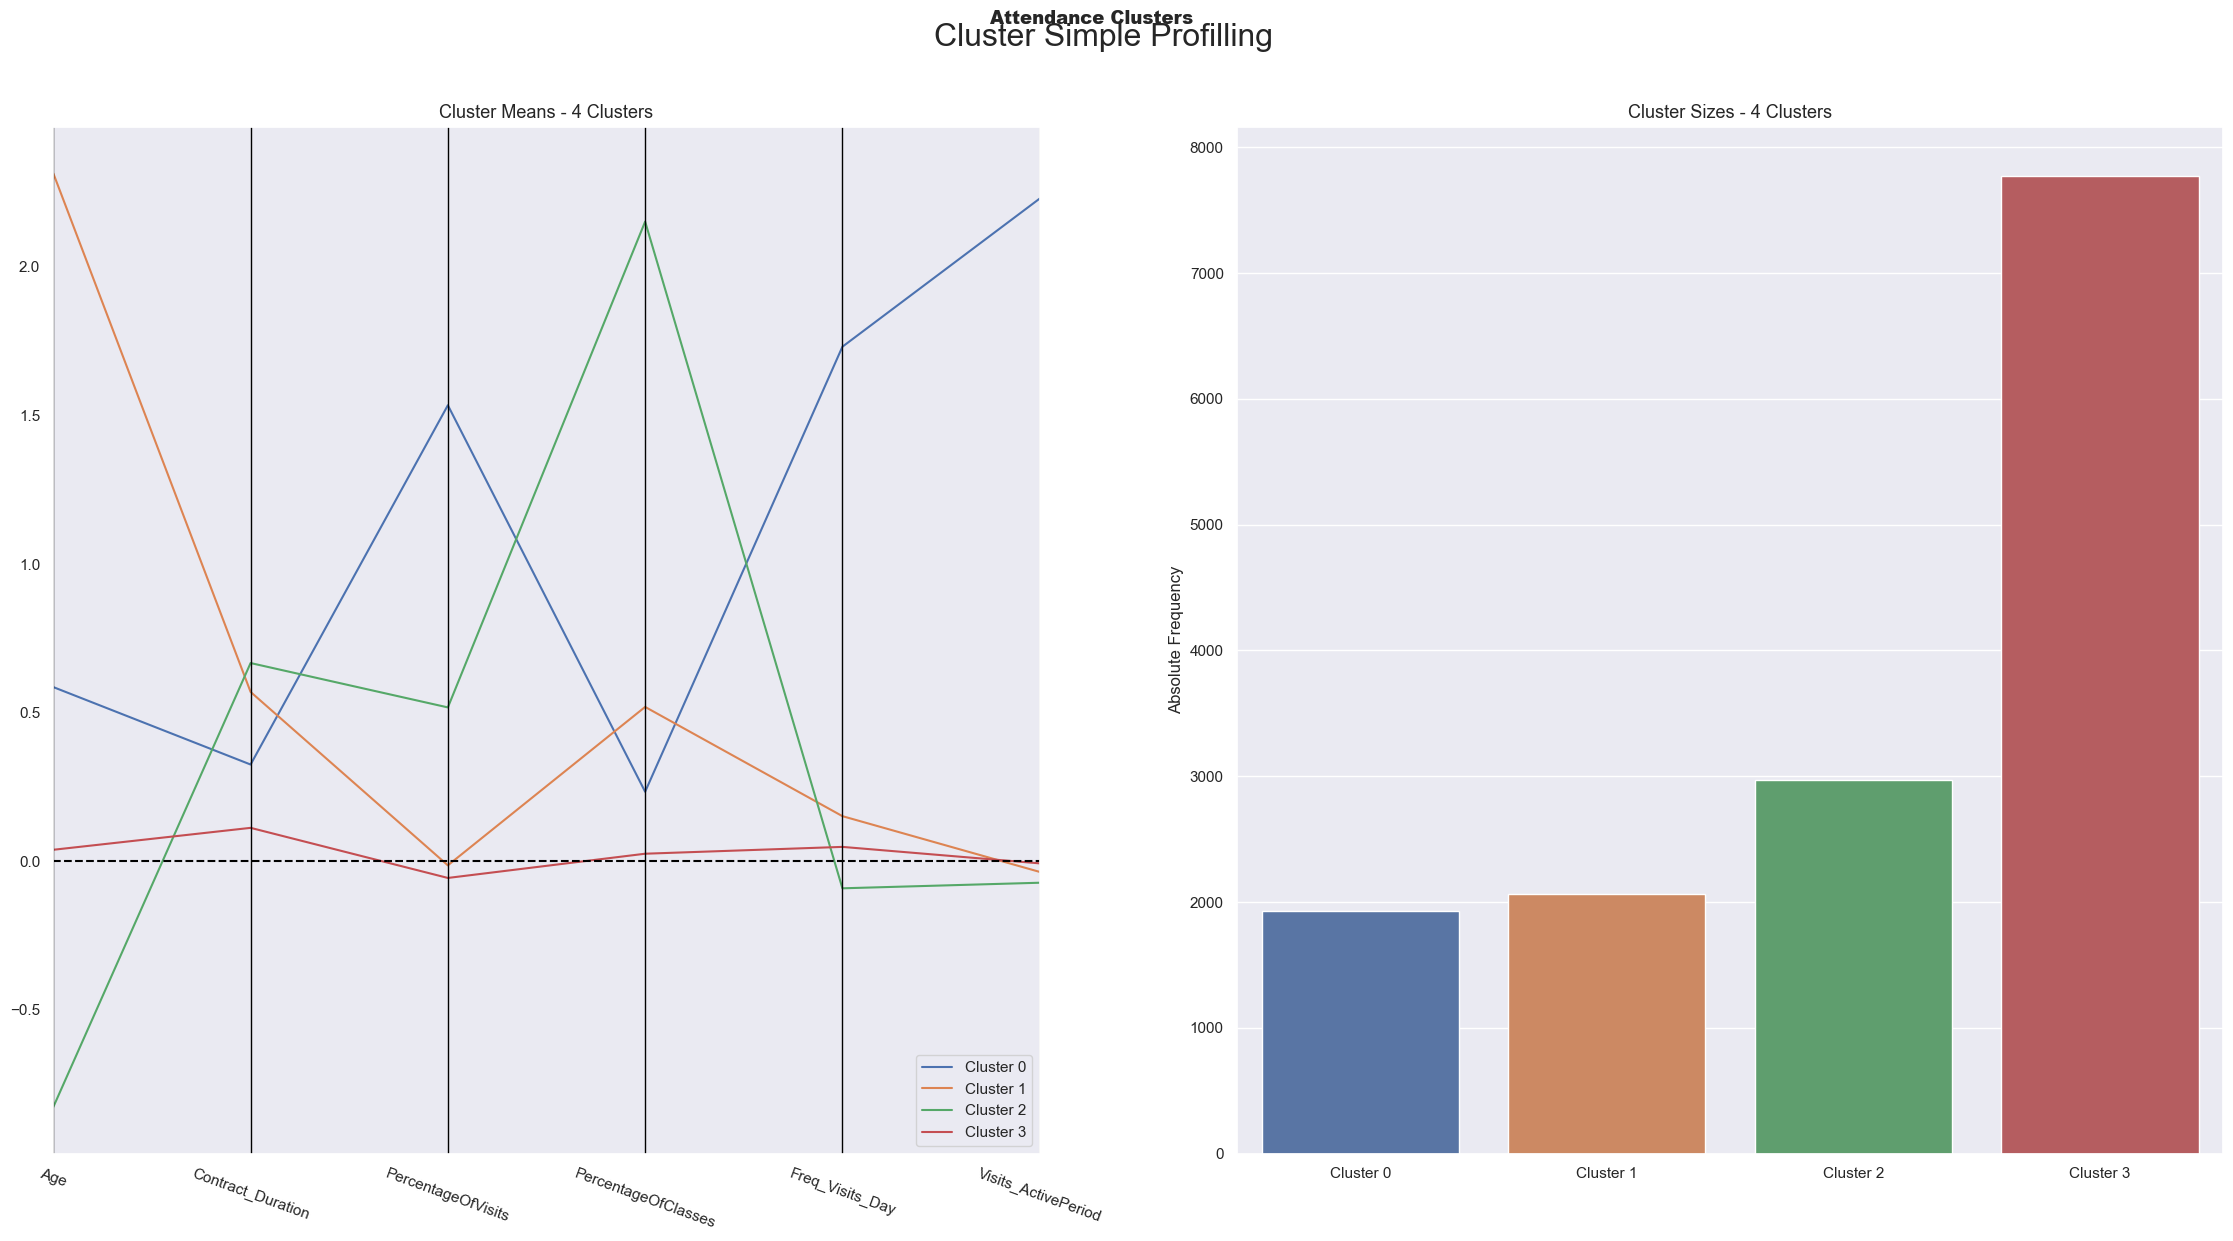

In [101]:
# Profilling each cluster (product, behavior, merged)
cluster_profiles(
    df = data[metric_features + ['attendance_labels']],
    label_columns = ['attendance_labels'], 
    figsize = (28, 13), 
    compar_titles = ["Attendance Clusters"]
)

In [102]:
df_compare = data[['attendance_labels','UseByTime', 'Dropout', 'Gender_Female']].groupby(['attendance_labels']).sum()

df_compare

,UseByTime,Dropout,Gender_Female
attendance_labels,,,
0,134,1300,1019
1,145,1666,1302
2,25,2039,1705
3,392,7098,4794


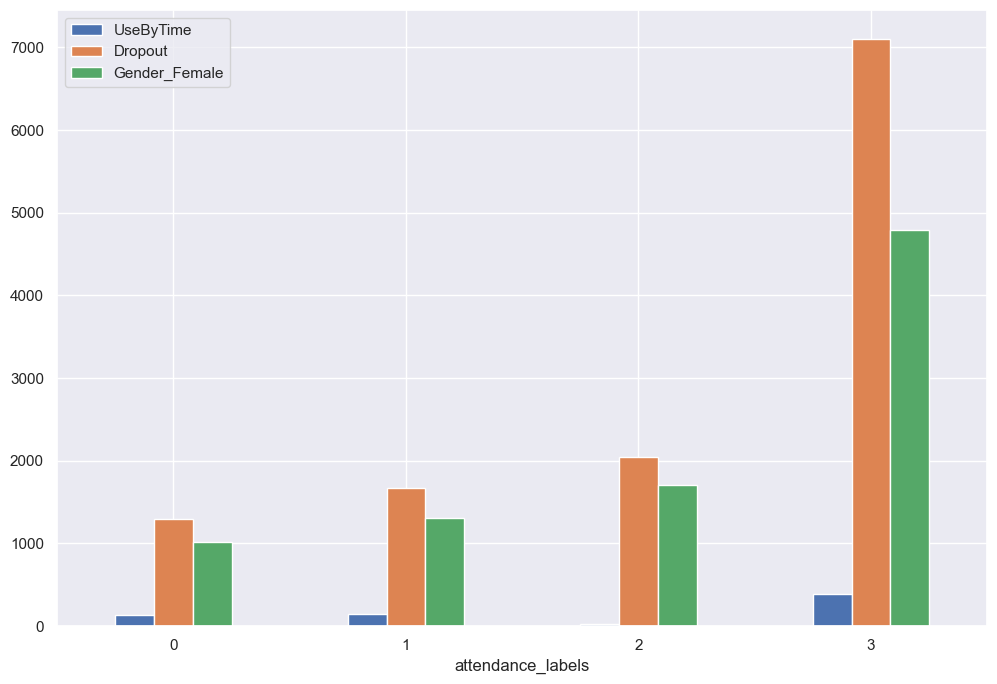

In [103]:
fig, ax = plt.subplots(figsize=(12,8))
df_compare.plot(kind='bar', stacked=False, ax=ax)
plt.xticks(rotation=0)
plt.show()

In [104]:
df_activities = data[['attendance_labels','AthleticsActivities', 'WaterActivities', 'FitnessActivities',
       'TeamActivities', 'RacketActivities', 'CombatActivities',
       'SpecialActivities', 'OtherActivities']].groupby(['attendance_labels']).sum()

df_activities

,AthleticsActivities,WaterActivities,FitnessActivities,TeamActivities,RacketActivities,CombatActivities,SpecialActivities,OtherActivities
attendance_labels,,,,,,,,
0,17.0,454.0,1422.0,31.0,21.0,90.0,104.0,3.0
1,19.0,608.0,1330.0,48.0,34.0,134.0,177.0,7.0
2,11.0,2122.0,124.0,546.0,249.0,111.0,27.0,6.0
3,61.0,1125.0,5682.0,173.0,42.0,1261.0,70.0,12.0


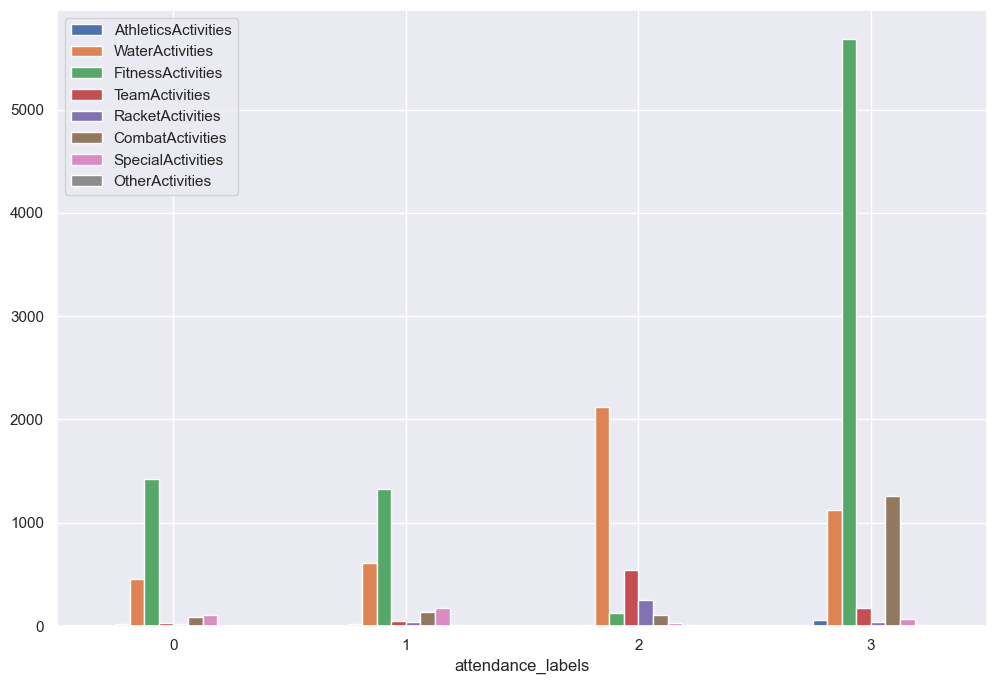

In [105]:
fig, ax = plt.subplots(figsize=(12,8))
df_activities.plot(kind='bar', stacked=False, ax=ax)
plt.xticks(rotation=0)
plt.show()